So far we've explored making a basic linear regression model based solely on speed,
and making a much more powerful model based on the image of the cryptokitty.

But interestingly, a cat doesn't look any different when it's speed changes, so there's information captured by the speed that we loose when we're only looking at the image.

One way to combine the power of our simple model and the power of our image regression model is to make a non-sequential model that has multiple branches that feed into one result.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tqdm
import matplotlib.pyplot as plt

train_df = pd.read_csv('/kaggle/input/how-much-would-you-pay-for-a-fake-cat/train.csv')
test_df = pd.read_csv('/kaggle/input/how-much-would-you-pay-for-a-fake-cat/test.csv')

image_dir = '/kaggle/input/part-3-resizing-our-images/resized'

def load_image_data(ids):
    image_data = []
    for img_id in tqdm.tqdm(ids):
        img_path = os.path.join(image_dir, img_id + '.png')
        im = cv2.imread(img_path)
        im = im / 255
        im = np.expand_dims(im, axis=-1)
        image_data.append(im)
    return image_data

train_images = load_image_data(train_df['id'])
test_images = load_image_data(test_df['id'])

100%|██████████| 120/120 [00:00<00:00, 241.65it/s]


In [2]:
train_image_data = np.array(train_images).astype(np.float16)
test_image_data = np.array(test_images).astype(np.float16)

In [3]:
train_df['price'] = train_df['price'].apply(lambda p: p.replace(',', ''))
train_labels = train_df['price'].values.astype(np.float16)
train_labels = np.clip(train_labels, 0, 100)
train_labels

array([ 2.13,  0.46, 10.  , ...,  1.44,  2.5 , 40.  ], dtype=float16)

In [4]:
import re

unit_map = {
    'm': 1,
    'h': 60,
    'd': 60*24,
    'w': 60*24*7,
}

# This function takes a speed string from out dataset
# and returns the number of minutes it represents
def clean_speed(speed_str):
    cooldown_str = re.findall('\((\d+[mhdw])\)', speed_str)[0]
    # At this point `cooldown_str` looks like "24h"
    cooldown_count = int(cooldown_str[:-1])
    cooldown_unit = cooldown_str[-1]
    return cooldown_count * unit_map[cooldown_unit]

train_speed = train_df['speed'].apply(clean_speed)
test_speed = test_df['speed'].apply(clean_speed)

In [5]:
from sklearn.model_selection import train_test_split

# image_train, image_val, speed_train, speed_val, label_train, label_val = train_test_split(
#     train_image_data, train_speed, train_labels, test_size=.2, random_state=1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# print(image_train.shape)
# print(image_val.shape)
# print(speed_train.shape)
# print(speed_val.shape)
# print(label_train.shape)
# print(label_val.shape)

In [7]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model

# Image Model
image_input = Input(shape=(200,200,3,))
image_model = Conv2D(16, (3, 3), activation="relu")(image_input)
image_model = MaxPooling2D((2,2))(image_model)
image_model = Conv2D(6, (3, 3), activation="relu")(image_input)
image_model = Flatten()(image_model)
image_model = Dense(32, activation='relu')(image_model)
image_model = Model(inputs=image_input, outputs=image_model)

# Speed Model
speed_input = Input(shape=(1,))
speed_model = Dense(32, activation="sigmoid")(speed_input)
speed_model = Model(inputs=speed_input, outputs=speed_model)

# combine the output of the two branches
combined_layer = Concatenate()([image_model.output, speed_model.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
final_model = Dense(2, activation="relu")(combined_layer)
final_model = Dense(1, activation="linear")(final_model)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(
    inputs=[image_model.input, speed_model.input],
    outputs=final_model)

In [8]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.004))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 198, 198, 6)  168         ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 235224)       0           ['conv2d_1[0][0]']               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                         

In [9]:
history = model.fit(
    x=(train_image_data, train_speed),
    y=train_labels,
    validation_split=0.2,
    epochs=40)

Epoch 1/40
50/50 [==============================] - 10s 30ms/step - loss: 12.6839 - val_loss: 12.5794
Epoch 2/40
50/50 [==============================] - 1s 15ms/step - loss: 12.4245 - val_loss: 12.4143
Epoch 3/40
50/50 [==============================] - 1s 14ms/step - loss: 12.2735 - val_loss: 12.2833
Epoch 4/40
50/50 [==============================] - 1s 15ms/step - loss: 12.1633 - val_loss: 12.1858
Epoch 5/40
50/50 [==============================] - 1s 15ms/step - loss: 12.0834 - val_loss: 12.1236
Epoch 6/40
50/50 [==============================] - 1s 15ms/step - loss: 12.0267 - val_loss: 12.0781
Epoch 7/40
50/50 [==============================] - 1s 15ms/step - loss: 11.9841 - val_loss: 12.0484
Epoch 8/40
50/50 [==============================] - 1s 15ms/step - loss: 11.9648 - val_loss: 12.0332
Epoch 9/40
50/50 [==============================] - 1s 15ms/step - loss: 11.9505 - val_loss: 12.0196
Epoch 10/40
50/50 [==============================] - 1s 14ms/step - loss: 11.9373 - val_lo

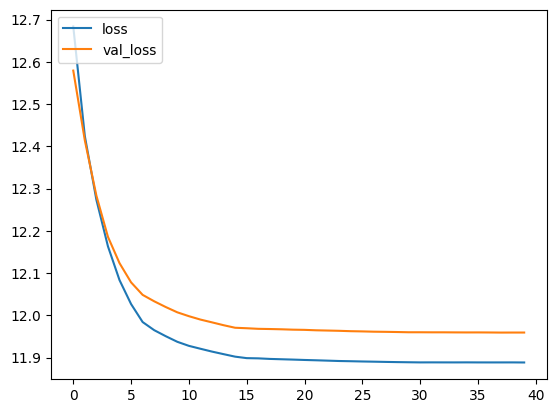

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper left')

In [11]:
test_df['price'] = model.predict((test_image_data, test_speed))

4/4 [==============================] - 0s 20ms/step


(array([  0.,   0.,   0.,   0.,   0., 120.,   0.,   0.,   0.,   0.]),
 array([1.33667541, 1.43667543, 1.53667545, 1.63667536, 1.73667538,
        1.83667541, 1.93667543, 2.03667545, 2.13667536, 2.2366755 ,
        2.33667541]),
 <BarContainer object of 10 artists>)

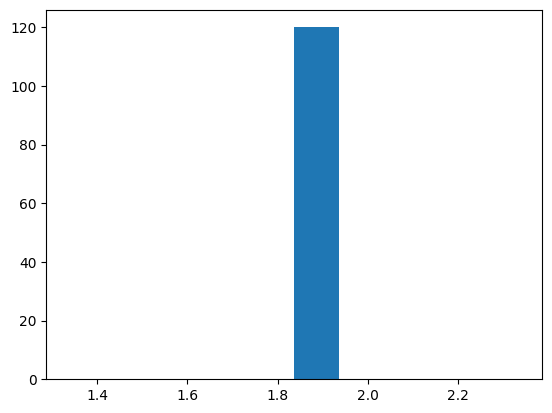

In [12]:
plt.hist(test_df['price'])

In [13]:
test_df[['id', 'price']].to_csv('submission.csv', index=False)